In [378]:
from bs4 import BeautifulSoup as BS
from shapely.geometry import Point
from IPython.display import display, clear_output

import urllib.request
import pandas as pd
import numpy as np
import re as r
import matplotlib.pyplot as plt
import ipywidgets as widgets
import geopandas as gpd
import matplotlib.patches as mp


%matplotlib inline 

#### Define url as data frame and read in

In [379]:
request = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result = urllib.request.urlopen(request)
resulttext = result.read()

#### Use BS constructor to pull data from HTML document 

In [380]:
soup = BS(resulttext, 'html.parser')

#### Look at well formed print of your soup

In [381]:
soup.prettify;

#### Find particular elements in the soup 

In [382]:
data = []
table = soup.find('table', "sortable wikitable")

#### Iterate through your table, grab each row, and pull the < th > and < td > elements into a dataset 

In [383]:
table = table.find_all('tr')

In [384]:
for row in table:
    cells = row.find_all('td')
    cells = [ele.text.strip() for ele in cells]
    data.append(cells)

#### Define data frame and its field names and remove extraneous records

In [385]:
quake_df = pd.DataFrame(data)
quake_df.drop(0, inplace=True)
quake_df = quake_df.rename(columns={0:'Origin', 1:'Country', 2:'Lat',\
                    3:'Long', 4:'Depth', 5:'Magnitude', 6:'Secondary Effects', 7:'PDE_Shaking',\
                                8:'PDE_Total', 9:'Utsu_Total', 10:'EM_DAT_Total', 11: 'Other'})

#### Replace empty strings with NaN 

In [386]:
quake_df = quake_df.apply(lambda x: x.str.strip()).replace('', np.nan)

#### Remove the footnotes from the 'Other Source Deaths' column

In [387]:
quake_df['Other'] = quake_df.Other.str.replace(r'+','')
quake_df['Other'] = quake_df.Other.str.replace(r',','')
quake_df['Other'] = quake_df.Other.str.extract('(\d+)', expand = True)
quake_df['EM_DAT_Total'] = quake_df.EM_DAT_Total.str.extract('(\d+)', expand = True)

#### Remove the footnotes from the 'Country' column

In [388]:
quake_df['Country'] = quake_df.Country.str.replace(r'\(.*','')

#### Convert Magnitude to a numeric

In [389]:
quake_df['Magnitude'] = quake_df.Magnitude.str.extract('(\d\.\d)', expand = True)

#### Clean 'Longitude' column

In [390]:
quake_df['Long'] = quake_df['Long'].str.replace('?', '')
quake_df['Long'] = quake_df['Long'].astype(str)
quake_df['Long'] = quake_df['Long'].apply(lambda x: x.strip()).replace('', np.nan)
quake_df['Long'] = quake_df['Long'].astype(float)

#### Clean 'Latitude' column

In [391]:
quake_df['Lat'] = quake_df['Lat'].astype(str)
quake_df['Lat'] = quake_df['Lat'].str.replace('?', '')
quake_df['Lat'] = quake_df['Lat'].str.replace('?', '')
quake_df['Lat'] = quake_df['Lat'].apply(lambda x: x.strip()).replace('', np.nan)
quake_df['Lat'] = quake_df['Lat'].astype(float)

#### Clean fatality data for creation of Deaths column

In [392]:
quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']] = quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']].fillna(-1)
quake_df['PDE_Total'] = quake_df['PDE_Total'].astype(float)
quake_df['Utsu_Total'] = quake_df['Utsu_Total'].astype(float)
quake_df['EM_DAT_Total']= quake_df['EM_DAT_Total'].astype(float)
quake_df['Other'] = quake_df['Other'].astype(float)

#### Create and apply 'max' function to fatality data to create Deaths column

In [393]:
def max(row):
        if row['Other'] >= row['PDE_Total'] and row['Other'] >= row['Utsu_Total']\
        and row['Other'] >= row['EM_DAT_Total']:
            return row['Other']
    
        elif row['PDE_Total'] >= row['Other'] and row['PDE_Total'] >= row['Utsu_Total']\
        and row['PDE_Total'] >= row['EM_DAT_Total']:
            return row['PDE_Total']

        elif row['Utsu_Total'] >= row['Other'] and row['Utsu_Total'] >= row['PDE_Total']\
        and row['Utsu_Total'] >= row['EM_DAT_Total']:
            return row['Utsu_Total']

        else: 
            return row['EM_DAT_Total']

quake_df['Deaths'] = quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other']].apply(max, axis=1)
quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']]=quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']].replace(-1.0,np.NaN)


#### Read in soil profile data file$ ^{1}$ with US lat-long

In [394]:
US_df = pd.read_csv('Data/vs30data_utf8.csv')
geometry = [Point(xy) for xy in zip(US_df.Longitude, US_df.Latitude)]
crs = {'init': 'epsg:4326'}

#### Create and apply 'soil category' $ ^{2, 3}$ function to soil profile data set

In [395]:
## Shear Wave Velocity is a measure of how fast a seismic body wave shakes the ground back and forth perpendicular to the
## direction the wave is moving. See footnote 3 for a glossary of earthquake terms and footnote 2 for a website with more details 
## on Shear Wave methodology. 

def soil_category(row):
        if row['Vs30 (m/s)'] > 1500:
            return 'Type A'
        
        elif row['Vs30 (m/s)'] <= 1500 and row['Vs30 (m/s)'] > 760:
            return 'Type B'
        
        elif row['Vs30 (m/s)'] <= 760 and row['Vs30 (m/s)'] > 360:
            return 'Type C'
        
        elif row['Vs30 (m/s)'] <= 360 and row['Vs30 (m/s)'] > 180:
            return 'Type D'
        
        elif row['Vs30 (m/s)'] < 180:
            return 'Type E'
        
        else:
            return 'No Category'
    
US_df['SoilProfileType'] = US_df.apply(soil_category, axis= 1)
US_df.crs = {'init': 'epsg:4326'}



#### Define soil data for California Longitudes and Latitudes  

In [396]:
Cal_Soil = US_df.query("34.3<Latitude<40.5")
Cal_Soil = Cal_Soil.query("-122.4<Longitude<-116.9")
## See Google Maps for Lat Long boundaries 

#### Define earthquake data for California Longitudes and Latitudes  

In [397]:
Cal_quake_df = quake_df.query("34.3<Lat<40.5")
Cal_quake_df = Cal_quake_df.query("-122.4<Long<-116.9")
## See Google Maps for Lat Long boundaries 

#### Read in California shape file $ ^{4}$


In [398]:
cal = gpd.read_file('Data\California County Shape Files\County\CaliforniaCounty.shp')
cal.crs = {'init': 'epsg:4326'}

#### Create variable drop down widget to a map of California and its respective earthquake and soil category data

In [399]:
variables = ["Depth", "Magnitude", "Deaths"]
variables.insert(0, 'Select a variable')

130      0.0
329     10.0
331     16.0
506      6.4
654     15.0
848     15.0
851     16.0
1205    16.0
Name: Depth, dtype: float64


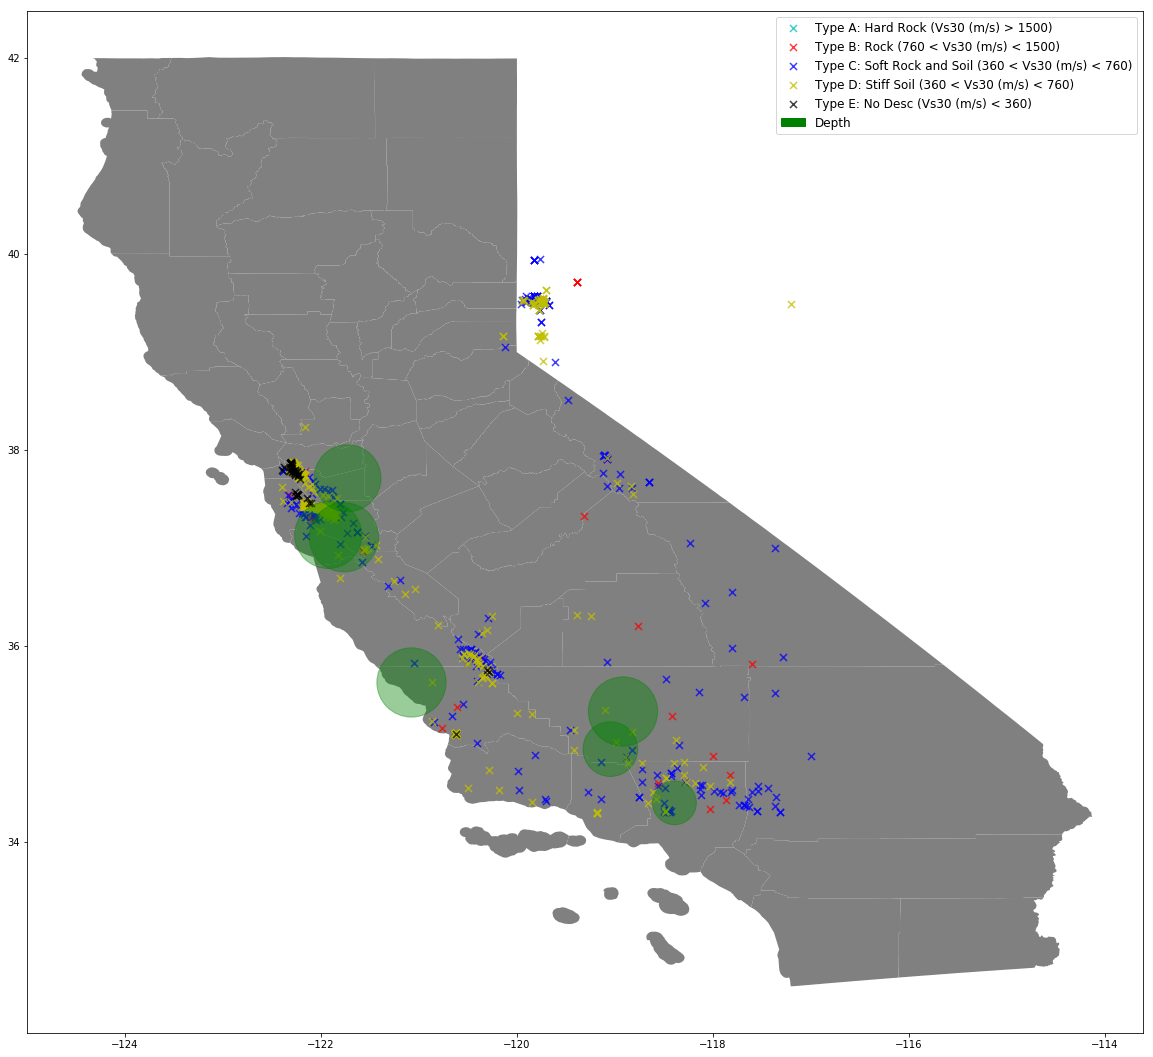

In [416]:
variable_dropdown = widgets.Dropdown(
    options=variables,
    value='Select a variable', 
    description='Variable:',
    disabled=False,
)

#define the behavior you want when a widget event is triggered (handler)
def response(change):
    clear_output()
    fig, ax = plt.subplots(figsize = (20, 20), subplot_kw = {'aspect': 'equal'})

    cal.plot(ax=ax, color="grey")

    A = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type A"'), x = 'Longitude', y = 'Latitude', 
                marker = 'x', s=50, alpha = 0.75, color = 'c')

    B = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type B"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'r')

    C = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type C"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'b')

    D = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type D"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'y')

    E = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type E"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'k')

    data = Cal_quake_df[''+change['new']+'']
    data = data.astype(list)
    data = data.fillna(0)
    data = data.astype(float)
    
    print(data)
    
    F = plt.scatter(Cal_quake_df['Long'], Cal_quake_df['Lat'], s=data*300, c = 'g',alpha=0.4)
    
    variable_patch = mp.Patch(color='g', label=''+change['new']+'')
    
    plt.legend((A, B, C, D, E, variable_patch),
           ('Type A: Hard Rock (Vs30 (m/s) > 1500)', 'Type B: Rock (760 < Vs30 (m/s) < 1500)',\
            'Type C: Soft Rock and Soil (360 < Vs30 (m/s) < 760)', 'Type D: Stiff Soil (360 < Vs30 (m/s) < 760)',\
            'Type E: No Desc (Vs30 (m/s) < 360)', ''+change['new']+''),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=12)

plt.show()

#specify the event trigger
variable_dropdown.observe(response, names='value')

#display widget
display(variable_dropdown)

In [ ]:
## All earthquakes from the available data set are located in areas that have high concentrations of Type C and D soils. 

## However there is no obvious relationship between Depth, Magnitude, Deaths, and soil type other than their occurance 
## from earthquakes happening over locations with soil types C and D. 


Text(0.5,1,'California Soil Frequency (available data set)')

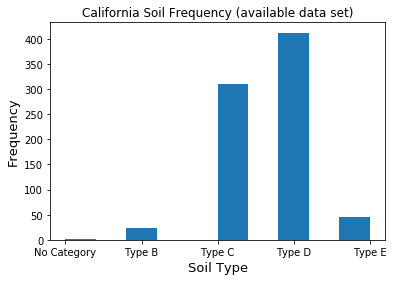

In [417]:
plt.hist(Cal_Soil['SoilProfileType'])
plt.xlabel('Soil Type', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('California Soil Frequency (available data set)')

In [ ]:
## The available data set from USGS has more points coresponding to Type C and Type D soils. 

#### Define soil data for Washington Longitudes and Latitudes  

In [402]:
Wash_Soil = US_df.query(" 45.543607 < Latitude < 49.016911")
Wash_Soil = Wash_Soil.query("-124.772117 < Longitude < -117.037742")
## See Google Maps for Lat Long boundaries 

#### Define earthquake data for Washington Longitudes and Latitudes  

In [403]:
Wash_quake_df = quake_df.query(" 45.543607 < Lat < 49.016911")
Wash_quake_df = Wash_quake_df.query("-124.772117 < Long < -117.037742")
## See Google Maps for Lat Long boundaries 

#### Read in Wasington shape file $ ^{5}$


In [404]:
wash = gpd.read_file('Data/tl_2017_53_sldu.shp')
wash.crs = {'init': 'epsg:4326'}

#### Create variable drop down widget to a map of Washington and its respective earthquake and soil category data

307     6.5
430     6.5
1130    6.8
Name: Magnitude, dtype: float64


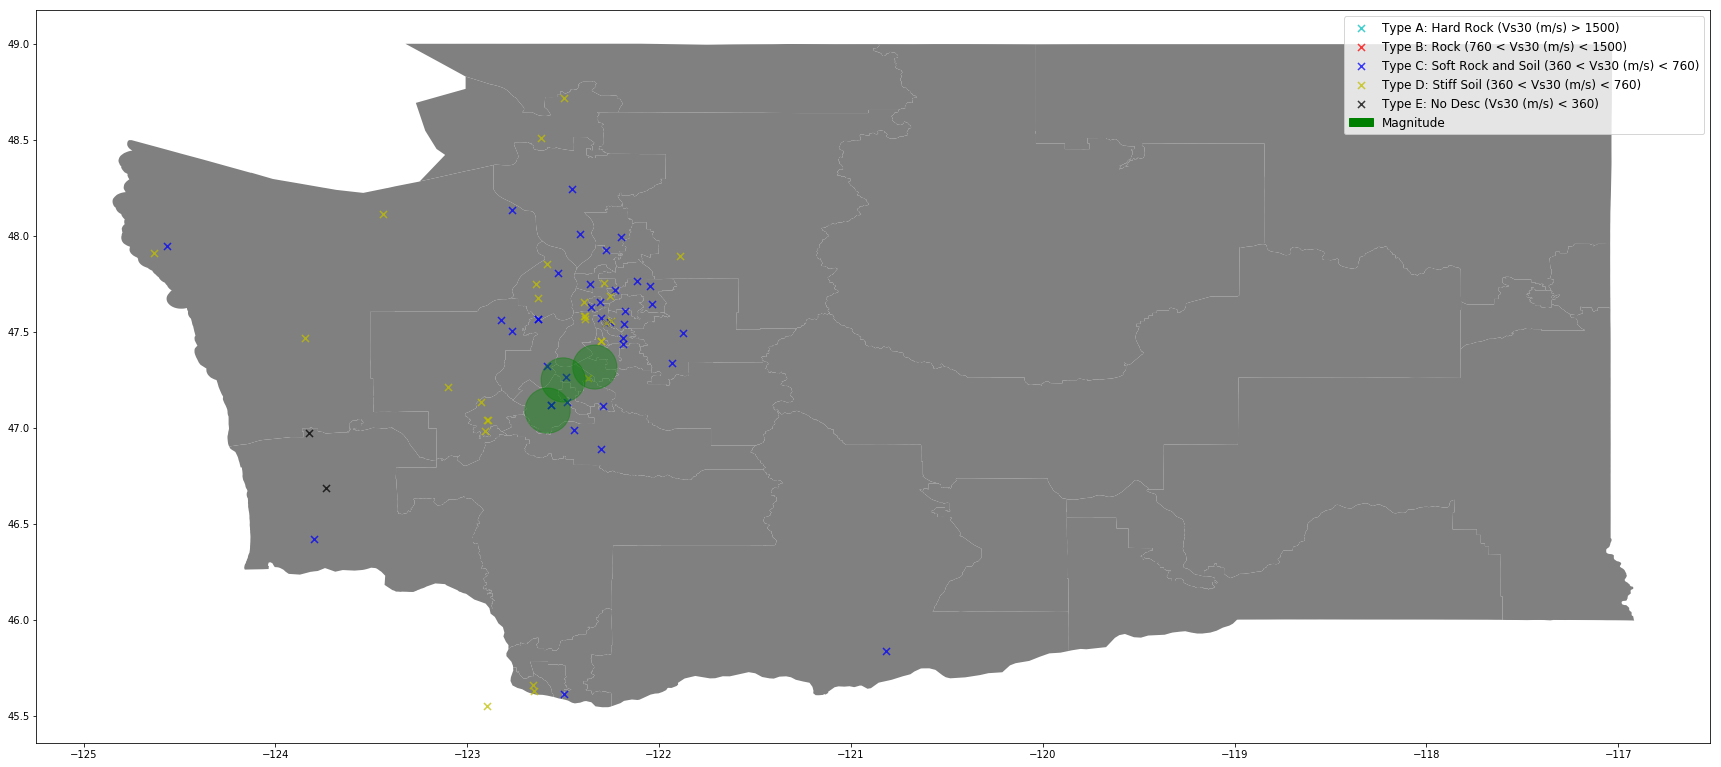

In [405]:
variable_dropdown = widgets.Dropdown(
    options=variables,
    value='Select a variable', 
    description='Variable:',
    disabled=False,
)

#define the behavior you want when a widget event is triggered (handler)
def response(change):
    clear_output()
    
    fig, ax = plt.subplots(figsize = (30, 30), subplot_kw = {'aspect': 'equal'})
    wash.plot(ax=ax, color="grey")

    A = plt.scatter(data = Wash_Soil.query('SoilProfileType == "Type A"'), x = 'Longitude', y = 'Latitude', 
                marker = 'x', s=50, alpha = 0.75, color = 'c')

    B = plt.scatter(data = Wash_Soil.query('SoilProfileType == "Type B"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'r')

    C = plt.scatter(data = Wash_Soil.query('SoilProfileType == "Type C"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'b')

    D = plt.scatter(data = Wash_Soil.query('SoilProfileType == "Type D"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'y')

    E = plt.scatter(data = Wash_Soil.query('SoilProfileType == "Type E"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'k')

    data = Wash_quake_df[''+change['new']+'']
    data = data.astype(list)
    data = data.fillna(0)
    data = data.astype(float)
    
    print(data)
    
    F = plt.scatter(Wash_quake_df['Long'], Wash_quake_df['Lat'], s=data*300, c = 'g',alpha=0.4)
    
    variable_patch = mp.Patch(color='g', label=''+change['new']+'')
    
    plt.legend((A, B, C, D, E, variable_patch),
           ('Type A: Hard Rock (Vs30 (m/s) > 1500)', 'Type B: Rock (760 < Vs30 (m/s) < 1500)',\
            'Type C: Soft Rock and Soil (360 < Vs30 (m/s) < 760)', 'Type D: Stiff Soil (360 < Vs30 (m/s) < 760)',\
            'Type E: No Desc (Vs30 (m/s) < 360)', ''+change['new']+''),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=12)

plt.show()

#specify the event trigger
variable_dropdown.observe(response, names='value')

#display widget
display(variable_dropdown)

In [ ]:
##As with California, all eathquake locations are synonomous with areas of Type C and Type D soils. 

## Again, there is no obvious relationship between Depth, Magnitude, Deaths, and soil type other than their occurance 
## from earthquakes happening over locations with soil types C and D. 

## More soil data is required across the world and borader US to make a strong conclusion that there is 
## a relationship between earthquake occurence and Type C and D soils. 

Text(0.5,1,'Washington Soil Frequency (available data set)')

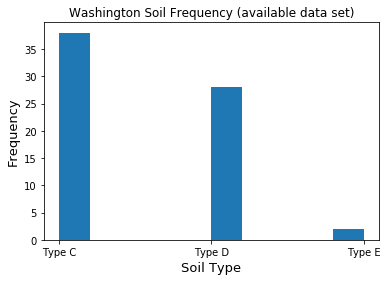

In [406]:
plt.hist(Wash_Soil['SoilProfileType'])
plt.xlabel('Soil Type', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Washington Soil Frequency (available data set)')

#### Define soil data for Wyoming Longitudes and Latitudes  

In [407]:
Wym_Soil = US_df.query("42.015800 < Latitude < 49.022710")
Wym_Soil = Wym_Soil.query("-117.238674 < Longitude < -111.086331")
## See Google Maps for Lat Long boundaries 

#### Define earthquake data for Wyoming Longitudes and Latitudes  

In [408]:
Wym_quake_df = quake_df.query("41.052195 < Lat < 45.032552")
Wym_quake_df = Wym_quake_df.query("-111.042385 < Long < -104.077054")
## See Google Maps for Lat Long boundaries 

#### Read in Wyoming shape file $ ^{6}$

In [409]:
Wym = gpd.read_file('Data/Wyoming/tl_2017_56_sldl.shp')
Wym.crs = {'init': 'epsg:4326'}

#### Create variable drop down widget to a map of Wyoming and its respective earthquake and soil category data

388    15.0
983     1.0
Name: Depth, dtype: float64


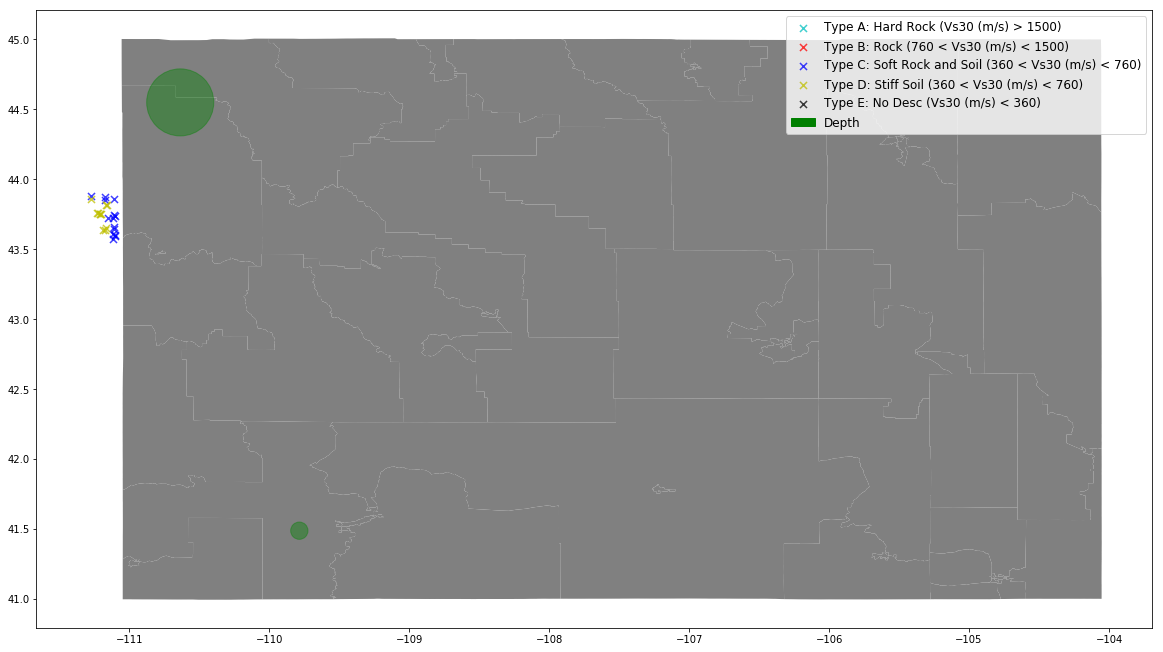

In [410]:
variable_dropdown = widgets.Dropdown(
    options=variables,
    value='Select a variable', 
    description='Variable:',
    disabled=False,
)

#define the behavior you want when a widget event is triggered (handler)
def response(change):
    clear_output()
    
    fig, ax = plt.subplots(figsize = (20, 20), subplot_kw = {'aspect': 'equal'})
    Wym.plot(ax=ax, color="grey")

    A = plt.scatter(data = Wym_Soil.query('SoilProfileType == "Type A"'), x = 'Longitude', y = 'Latitude', 
                marker = 'x', s=50, alpha = 0.75, color = 'c')

    B = plt.scatter(data = Wym_Soil.query('SoilProfileType == "Type B"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'r')

    C = plt.scatter(data = Wym_Soil.query('SoilProfileType == "Type C"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'b')

    D = plt.scatter(data = Wym_Soil.query('SoilProfileType == "Type D"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'y')

    E = plt.scatter(data = Wym_Soil.query('SoilProfileType == "Type E"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=50, alpha = 0.75, color = 'k')

    data = Wym_quake_df[''+change['new']+'']
    data = data.astype(list)
    data = data.fillna(0)
    data = data.astype(float)
    
    print(data)
    
    F = plt.scatter(Wym_quake_df['Long'], Wym_quake_df['Lat'], s=data*300, c = 'g',alpha=0.4)
    
    variable_patch = mp.Patch(color='g', label=''+change['new']+'')
    
    plt.legend((A, B, C, D, E, variable_patch),
           ('Type A: Hard Rock (Vs30 (m/s) > 1500)', 'Type B: Rock (760 < Vs30 (m/s) < 1500)',\
            'Type C: Soft Rock and Soil (360 < Vs30 (m/s) < 760)', 'Type D: Stiff Soil (360 < Vs30 (m/s) < 760)',\
            'Type E: No Desc (Vs30 (m/s) < 360)', ''+change['new']+''),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=12)

plt.show()

#specify the event trigger
variable_dropdown.observe(response, names='value')

#display widget
display(variable_dropdown)

#### Sources:

#### https://earthquake.usgs.gov/data/vs30/us/ $ ^{1}$


#### https://pubs.usgs.gov/of/1997/ofr-97-501/ofr-97-501.html $ ^{2}$

#### https://earthquake.usgs.gov/learn/glossary/?term=S%20wave $ ^{3}$

#### http://52.26.186.219/internships/useit/content/california-counties-shapefiles $ ^{4}$

#### https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2017&layergroup=State+Legislative+Districts $ ^{5, 6}$

